In [17]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/PTKD/GAS.csv')
df=df.reset_index()['Price']
df

0        98700
1       102900
2        99600
3        97500
4        97200
         ...  
1246     92900
1247     92800
1248     92000
1249     92000
1250     94000
Name: Price, Length: 1251, dtype: int64

In [19]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df).reshape(-1,1))

In [20]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [21]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [22]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [23]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [24]:


# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [25]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 4s 42ms/step - loss: 0.1047 - val_loss: 0.0063
Epoch 2/100
13/13 [==============================] - 0s 12ms/step - loss: 0.0217 - val_loss: 0.0201
Epoch 3/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0101 - val_loss: 0.0181
Epoch 4/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0056 - val_loss: 0.0039
Epoch 5/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0037 - val_loss: 0.0083
Epoch 6/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 7/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0017 - val_loss: 0.0035
Epoch 8/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 9/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 10/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 0.0024
E

In [26]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 22ms/step


In [27]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [28]:
train_size1 = int(0.7 * len(df))
test_size1 = int(0.2 * len(df))

train_data1 = df[:train_size1]
test_data1 = df[train_size1:train_size1+test_size1]
val_data1 = df[train_size1+test_size1:]

# re make predictions on the testing set
x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1)

# re make predictions on the validate set
x_val1 = np.array(val_data1.index).reshape(-1, 1)
y_val1 = np.array(val_data1)


In [29]:
# 11. Đánh giá độ chính xác thuật toán
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val1)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test1)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val1 - y_pred_val) / y_val1)) * 100
test_mape = np.mean(np.abs((y_test1 - y_pred) / y_test1)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val1))
test_mae = np.mean(np.abs(y_pred - y_test1))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 11296.913793922888
Testing RMSE: 10179.542980409695
Validation MAPE: 9.394653621468821
Testing MAPE: 7.527513023709824
Validation MAE: 9856.634459325396
Testing MAE: 8008.340189597316


In [30]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=66
i=0
while(i<30):

    if(len(temp_input)>66):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.5090798]
67
1 day input [0.66760733 0.66107497 0.65062319 0.66107497 0.67936558 0.69112383
 0.69373677 0.70810797 0.70288208 0.69373677 0.66238144 0.65062319
 0.64147788 0.64409083 0.64017141 0.63494552 0.63363905 0.62841316
 0.65062319 0.63886494 0.63363905 0.62841316 0.63494552 0.62710669
 0.62710669 0.6218808  0.61796138 0.59575135 0.60097724 0.59967077
 0.60228371 0.57746074 0.56570249 0.5604766  0.54479893 0.55002482
 0.54218599 0.51213713 0.49776593 0.51605654 0.50037888 0.50821771
 0.49776593 0.49645946 0.51213713 0.52520185 0.5134436  0.50037888
 0.50429829 0.50037888 0.50299182 0.49645946 0.51083066 0.53565363
 0.53304068 0.5134436  0.50429829 0.53304068 0.51997596 0.52128243
 0.50952418 0.50821771 0.49776593 0.49776593 0.52389538 0.50907981]
1 day output [[0.50196946]]
2 day input [0.66107497 0.65062319 0.66107497 0.67936558 0.69112383 0.69373677
 0.70810797 0.70288208 0.69373677 0.66238144 0.65062319 0.64147788
 0.64409083 0.64017141 0.63494552 0.63363905 0.62841316 0.650

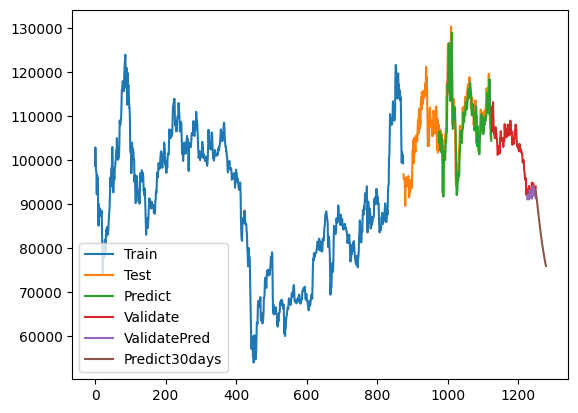

In [31]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()